In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.datasets import fetch_20newsgroups
import stop_words
import gensim
import nltk
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [96]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [97]:
EXCLUDE_SYMBOLS_STR = ''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є',
                               '‹', '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—',
                               '‘', '\x7f', '\xad', '¤', '\xa0'])

In [125]:
regex_puncts = re.compile('[%s]' % re.escape(string.punctuation))
regex_symbs = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_digits = re.compile('[%s]' % re.escape(string.digits))
regex_spaces = re.compile('[%s]' % string.printable + string.whitespace)
regex_emoji = re.compile("["
                         "\U0001F600-\U0001F64F"  # emoticons
                         "\U0001F300-\U0001F5FF"  # symbols & pictographs
                         "\U0001F680-\U0001F6FF"  # transport & map symbols
                         "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         "]+")
morph = pymorphy2.MorphAnalyzer()

N_TOPICS = 8

In [126]:
data_train = list(pd.read_csv('go_V.csv', sep = ';')['text'])

#fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes')).data

print(len(data_train))

1000


In [127]:
texts_prep = []
for txt in data_train:
    if (txt==txt):
        texts_prep.append(re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', txt))

In [128]:
texts_prep = [regex_emoji.sub(' ', txt) for txt in texts_prep]

In [129]:
texts_prep = [regex_puncts.sub(' ', txt) for txt in texts_prep]

In [130]:
texts_prep = [regex_symbs.sub('', txt) for txt in texts_prep]

In [131]:
texts_prep = [regex_digits.sub(' ', txt) for txt in texts_prep]

In [132]:
texts_prep = [regex_spaces.sub(' ', txt) for txt in texts_prep]

In [133]:
texts_prep = [txt.strip().replace('\t', ' ').replace('\n', ' ').lower() for txt in texts_prep]

In [134]:
texts_prep = [re.sub( '\s+', ' ', txt).strip() for txt in texts_prep]

In [135]:
texts_prep[:20]

['ученые выяснили что водные и околоводные птицы в болотах флориды специально строят гнезда поблизости от аллигаторов рептилии выполняют функции телохранителей отпугивая от птиц других хищников зато расплачиваются с ними пернатые своими птенцами выпадающими из гнезд об этом открытии сообщается в журнале plos one для цапель аистов ибисов и колпиц флориды наибольшую опасность представляют хищники млекопитающие еноты и опоссумы они разоряют гнезда и убивают птенцов по этой причине птицы предпочитают гнездиться неподалеку от аллигаторов зоологи захотели выяснить что такое соседство дает рептилиям и приносит ли оно им выгоду они сравнили массу тела самок аллигаторов живущих рядом с птицами в болотах эверглейдс и в отдалении от пернатых ученые брали анализ крови и измеряли массу и длину пресмыкающихся оказалось что жизнь рядом с гнездами птиц делает аллигаторов примерно на процентов упитаннее дело в том что птицы платят своим защитникам дань лишними птенцами околоводные птицы обычно откладыв

In [136]:
stops = stop_words.get_stop_words('ru')
wnl = nltk.WordNetLemmatizer()
stemmer = PorterStemmer()

In [137]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Никита\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [138]:
corpus = []

for sentence in log_progress(texts_prep[::]):
    tokens = sentence.split(' ')
#     tokens = [t for t in tokens if t not in stops]
    tokens = [wnl.lemmatize(t) for t in tokens if t not in stops]
#     tokens = [stemmer.stem(t) for t in tokens if t not in stops]
    tokens = [t for t in tokens if len(t) >= 3]
    corpus.append(tokens)

In [139]:
vectorizer = TfidfVectorizer()

In [140]:
X = vectorizer.fit_transform([' '.join(tokens) for tokens in corpus])

print(X.shape)

(999, 32751)


In [141]:
vectorizer.vocabulary_

{'ученые': 30269,
 'выяснили': 5799,
 'водные': 4633,
 'околоводные': 17154,
 'птицы': 23050,
 'болотах': 3383,
 'флориды': 30660,
 'специально': 27061,
 'строят': 27796,
 'гнезда': 6201,
 'поблизости': 19536,
 'аллигаторов': 1973,
 'рептилии': 24340,
 'выполняют': 5550,
 'функции': 30876,
 'телохранителей': 28475,
 'отпугивая': 18197,
 'птиц': 23047,
 'хищников': 31115,
 'расплачиваются': 23759,
 'пернатые': 19093,
 'своими': 25251,
 'птенцами': 23045,
 'выпадающими': 5507,
 'гнезд': 6200,
 'открытии': 18044,
 'сообщается': 26718,
 'журнале': 8534,
 'plo': 1044,
 'one': 951,
 'цапель': 31311,
 'аистов': 1770,
 'ибисов': 9633,
 'колпиц': 11529,
 'наибольшую': 14953,
 'опасность': 17275,
 'представляют': 21486,
 'хищники': 31114,
 'млекопитающие': 14285,
 'еноты': 8330,
 'опоссумы': 17357,
 'разоряют': 23538,
 'убивают': 29369,
 'птенцов': 23046,
 'причине': 22219,
 'предпочитают': 21398,
 'гнездиться': 6203,
 'неподалеку': 15855,
 'зоологи': 9596,
 'захотели': 9308,
 'выяснить': 5803,


In [142]:
keys = list(vectorizer.vocabulary_.keys())
values = list(vectorizer.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

print(len(keys), len(values), len(words_sorted))

32751 32751 32751


In [212]:
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

N_TOPICS = 8
#svd = TruncatedSVD(n_components=N_TOPICS, n_iter=10).fit(X)

#svd = NMF(n_components=N_TOPICS)
#svd.fit(X)

svd =FastICA(n_components=N_TOPICS)
svd.fit(X.toarray())

#svd =

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=8, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

['министр' 'роста' 'улюкаев' 'экономического' 'миллиарда' 'миллиардов'
 'рублей' 'россии' 'ввп' 'процента']
[0.04012889 0.04152455 0.04174101 0.0507648  0.05160993 0.05610074
 0.06195286 0.06712865 0.08785332 0.19704506]

['опек' 'заморозить' 'венесуэла' 'добычи' 'россия' 'ввп' 'миллиардов'
 'добычу' 'министр' 'процента']
[0.00684821 0.00701608 0.0076747  0.00808098 0.00918117 0.00982725
 0.00984685 0.01003609 0.01259064 0.02123068]

['присоединиться' 'заморозке' 'саудовская' 'аравия' 'заморозить'
 'венесуэла' 'добычу' 'опек' 'добычи' 'нефти']
[0.04597784 0.04755773 0.04872048 0.04872048 0.05545439 0.05725818
 0.06501706 0.07928447 0.09567777 0.17155862]

['стоимость' 'билетов' 'полеты' 'туристов' 'рейсы' 'тысячи' 'москвы'
 'авиакомпания' 'билеты' 'рублей']
[0.05025368 0.05587763 0.05636896 0.05793532 0.0581927  0.06027664
 0.06786359 0.07464812 0.07543392 0.12743561]

['джанни' 'президента' 'секретаря' 'выборов' 'организации' 'платини'
 'федерации' 'футбола' 'инфантино' 'фифа']
[0.052

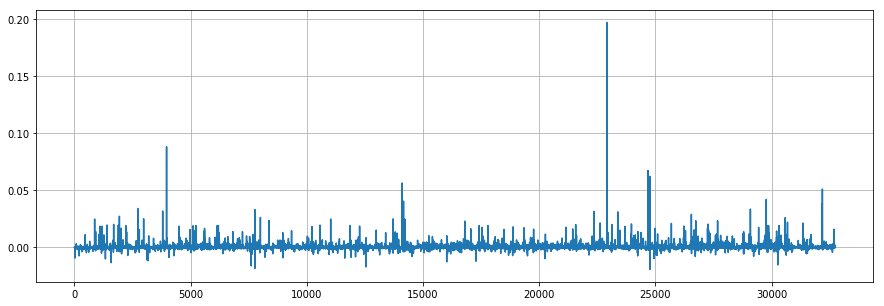

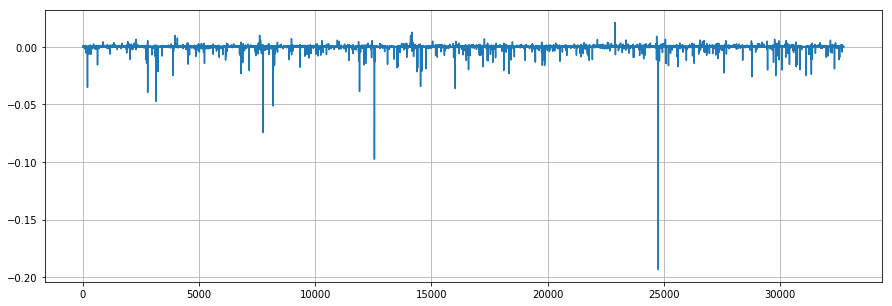

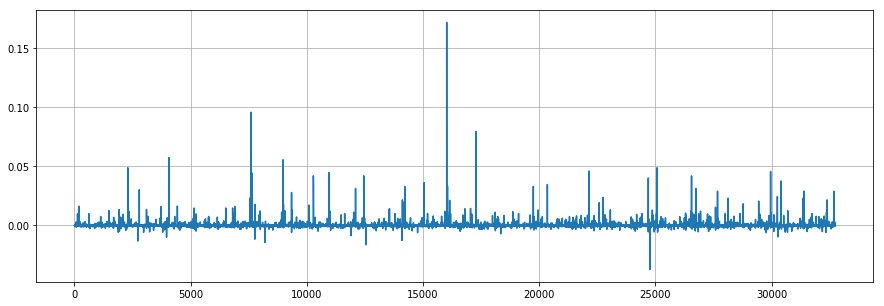

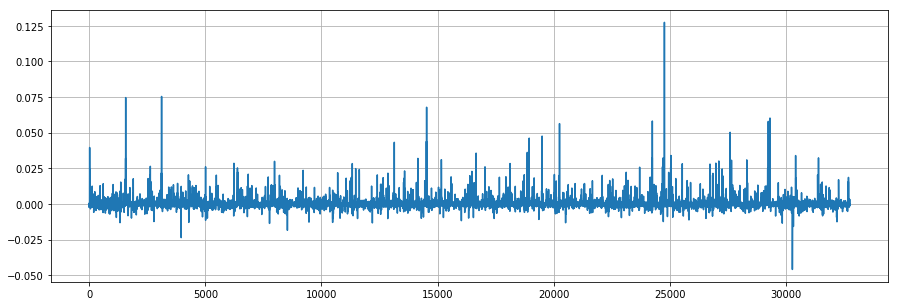

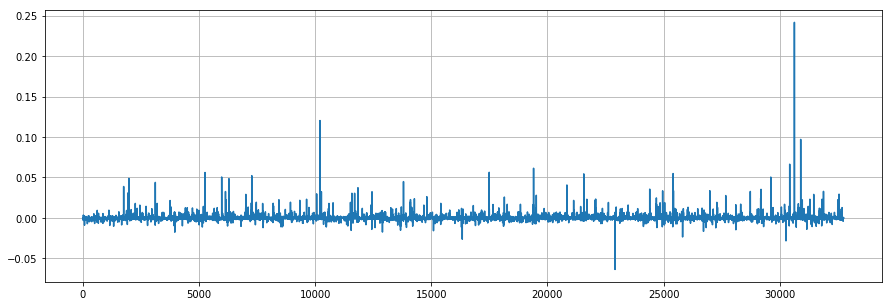

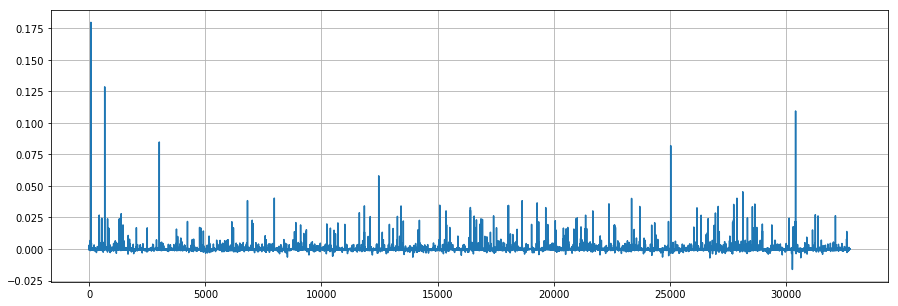

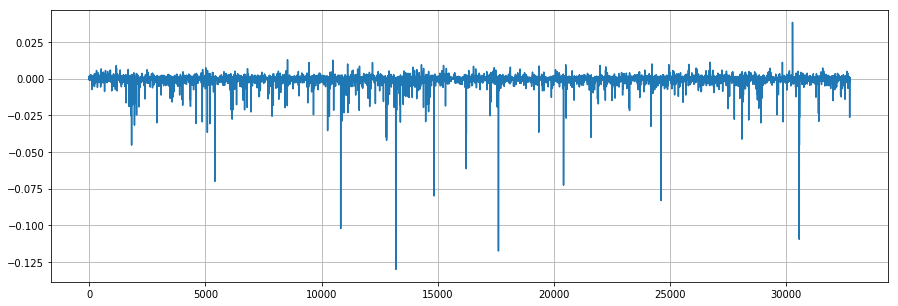

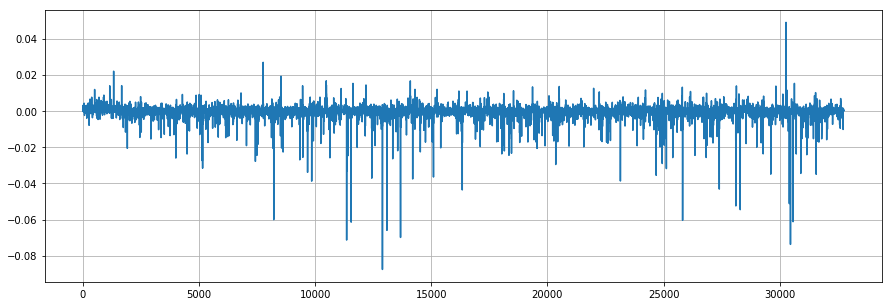

In [213]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(svd.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
    
    tmp = stub.copy()
    tmp[i] = 1
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.grid(True)
#     break

In [214]:
dictionary = corpora.Dictionary(corpus)

In [215]:
X_bow = [dictionary.doc2bow(text) for text in corpus]

In [216]:
lda_gensim = gensim.models.ldamodel.LdaModel(X_bow, num_topics=N_TOPICS, id2word=dictionary, iterations=10)

In [217]:
lda_gensim.print_topics()

[(0,
  '0.005*"февраля" + 0.004*"рублей" + 0.004*"россии" + 0.003*"сообщает" + 0.003*"рубля" + 0.002*"долларов" + 0.002*"ранее" + 0.002*"процента" + 0.002*"заявил" + 0.002*"компании"'),
 (1,
  '0.006*"февраля" + 0.005*"россии" + 0.003*"сообщает" + 0.002*"долларов" + 0.002*"ранее" + 0.002*"процента" + 0.002*"рублей" + 0.002*"марта" + 0.002*"ученые" + 0.001*"словам"'),
 (2,
  '0.006*"февраля" + 0.004*"россии" + 0.003*"сообщает" + 0.002*"ранее" + 0.002*"ученые" + 0.002*"компании" + 0.002*"марта" + 0.002*"рублей" + 0.002*"заявил" + 0.002*"долларов"'),
 (3,
  '0.005*"февраля" + 0.004*"россии" + 0.003*"рублей" + 0.003*"сообщает" + 0.002*"процента" + 0.002*"долларов" + 0.002*"рубля" + 0.002*"сша" + 0.002*"ранее" + 0.001*"заявил"'),
 (4,
  '0.005*"россии" + 0.004*"февраля" + 0.003*"сообщает" + 0.003*"долларов" + 0.002*"процента" + 0.002*"рублей" + 0.002*"ранее" + 0.002*"марта" + 0.002*"сша" + 0.002*"заявил"'),
 (5,
  '0.005*"россии" + 0.005*"февраля" + 0.003*"сообщает" + 0.003*"процента" + 0.0

In [218]:
lda_sklearn = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

iteration: 1 of max_iter: 10, perplexity: 1291674.4289
iteration: 2 of max_iter: 10, perplexity: 1238048.6116
iteration: 3 of max_iter: 10, perplexity: 1197547.7988
iteration: 4 of max_iter: 10, perplexity: 1173117.9707
iteration: 5 of max_iter: 10, perplexity: 1157318.4962
iteration: 6 of max_iter: 10, perplexity: 1140904.7792
iteration: 7 of max_iter: 10, perplexity: 1125650.7907
iteration: 8 of max_iter: 10, perplexity: 1110694.0370
iteration: 9 of max_iter: 10, perplexity: 1094318.9552
iteration: 10 of max_iter: 10, perplexity: 1079014.0912


In [219]:
lda_sklearn.components_.shape

(8, 32751)

In [228]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(lda_sklearn.components_[i])[-10:]
    names = []
    weights = []
    w = np.sort(svd.components_[i])[-10:]
    for i in range (len(w)):
        if w[i]>0.022:
            names.append(words_sorted[ind][i])
            weights.append(w[i])
    print(names)
    print(weights)
    print()
#     break

['экономики', 'ссср', 'февраля', 'сообщает', 'ученые', 'рублей', 'россии', 'долларов', 'миллиарда', 'процента']
[0.04012889204317864, 0.041524551966436105, 0.04174100635608302, 0.050764798961249434, 0.05160992617988751, 0.056100739127675235, 0.06195286103930468, 0.06712865444830315, 0.08785332332944172, 0.19704505784505552]

[]
[]

['билеты', 'стоимость', 'полеты', 'февраля', 'бензин', 'авиакомпания', 'фифа', 'россии', 'процента', 'рублей']
[0.04597784394921317, 0.04755772643290105, 0.04872048006855417, 0.04872048006855417, 0.05545438690001055, 0.057258184271217455, 0.06501705766145423, 0.07928446941246964, 0.09567777367476055, 0.17155861547367054]

['марта', 'сообщает', 'ска', 'процента', 'долларов', 'опек', 'добычи', 'россии', 'февраля', 'нефти']
[0.050253682492170534, 0.05587762907335138, 0.05636896427359481, 0.05793532371976422, 0.05819270312973978, 0.06027664194321408, 0.06786358980407053, 0.07464812014174071, 0.07543392171900992, 0.12743561169238973]

['отелей', 'организации', 'у